In [1]:
using Muon
using Plots
using StatsPlots
using NearestNeighbors
using Distances

# Functions

In [2]:
function intrinsic_stability(adata; xkey = "X_ebd", vkey = "velocity_ebd", celltype = "clusters", n_neighbors = 30)
    celltype = adata.obs[!, celltype]
    labels = sort(unique(celltype))
    velocity_projection = adata.obsm[vkey]'
    embedding = adata.obsm[xkey]'

    celltype_cosine_similarity = Array{Array}(undef, 0)
    for label in labels
        temp_velocity_projection = velocity_projection[:, celltype .== label]
        temp_embedding = embedding[:, celltype .== label]

        kdTree = KDTree(temp_embedding)

        cell_cosine_similarity = Array{Float32}(undef, 0)
        for i in axes(temp_embedding, 2)
            idxs, _ = knn(kdTree, temp_embedding[:, i], n_neighbors + 1, true)
            idxs = idxs[2:end]
            cos_sim = []
            for j in axes(idxs, 1)
                if ~isnan(cosine_dist(temp_velocity_projection[:, i], temp_velocity_projection[:, idxs[j]]))
                    push!(cos_sim, 1 - cosine_dist(temp_velocity_projection[:, i], temp_velocity_projection[:, idxs[j]]))
                end
            end
            if ~isempty(cos_sim)
                cos_sim = sum(cos_sim) / length(cos_sim)
                push!(cell_cosine_similarity, cos_sim)
            end
        end

        push!(celltype_cosine_similarity, cell_cosine_similarity)
    end

    celltype_intrinsic_stability = Dict(k => v for (k, v) in zip(labels, celltype_cosine_similarity))

    return celltype_intrinsic_stability
end

intrinsic_stability (generic function with 1 method)

In [3]:
function extrinsic_stability(adata, differentiation_direction; xkey = "X_ebd", vkey = "velocity_ebd", celltype = "clusters", n_neighbors = 30)
    celltype_extrinsic_stability = Dict(item => Array{Float32}(undef, 0) for item in keys(differentiation_direction))
    
    celltype = adata.obs[!, celltype]
    labels = sort(unique(celltype))
    velocity_projection = adata.obsm[vkey]'
    embedding = adata.obsm[xkey]'

    kdTree = KDTree(embedding)

    for i in axes(embedding, 2)
        idxs, _ = knn(kdTree, embedding[:, i], n_neighbors + 1, true)
        idxs = idxs[2:end]

        if ~haskey(celltype_extrinsic_stability, celltype[i])
            continue
        end

        if typeof(differentiation_direction[celltype[i]]) == Vector{String}
            if length(findall(x -> x in differentiation_direction[celltype[i]], celltype[idxs])) == 0
                continue
            end
        elseif ~(differentiation_direction[celltype[i]] in celltype[idxs])
            continue
        end

        temp_cos_sim = []
        X̂ = embedding[:, idxs] .- embedding[:, i]

        for j in axes(X̂, 2)
            if typeof(differentiation_direction[celltype[i]]) == Vector{String}
                if celltype[idxs[j]] in differentiation_direction[celltype[i]]
                    push!(temp_cos_sim, 1 - cosine_dist(X̂[:, j], velocity_projection[:, i]))
                end
            else
                if celltype[idxs[j]] == differentiation_direction[celltype[i]]
                    push!(temp_cos_sim, 1 - cosine_dist(X̂[:, j], velocity_projection[:, i]))
                end
            end
        end

        temp_cos_sim = filter(isfinite, temp_cos_sim)
        if ~isempty(temp_cos_sim)
            temp_cos_sim = sum(temp_cos_sim) / length(temp_cos_sim)
            push!(celltype_extrinsic_stability[celltype[i]], temp_cos_sim)
        end
    end

    return celltype_extrinsic_stability
end

extrinsic_stability (generic function with 1 method)

In [4]:
function merge_for_boxplot(julovelo, scvelo, deepvelo, celldancer, labels)
    X = Array{Float32}(undef, 0)
    models = Array{Float32}(undef, 0)
    groups = Array{Float32}(undef, 0)

    for label in labels
        x = vcat(
            julovelo[label], 
            scvelo[label], 
            deepvelo[label], 
            celldancer[label]
        )
        model = vcat(
            ["JuloVelo" for i in 1:length(julovelo[label])],
            ["scVelo" for i in 1:length(scvelo[label])],
            ["DeepVelo" for i in 1:length(deepvelo[label])],
            ["cellDancer" for i in 1:length(celldancer[label])]
        )
        group = [label for i in 1:length(model)]

        X = vcat(X, x)
        models = vcat(models, model)
        groups = vcat(groups, group)
    end

    return X, models, groups
end

merge_for_boxplot (generic function with 1 method)

# Differentiation flow

In [5]:
differentiation_direction = Dict(
    "Ductal" => "Ngn3 low EP",
    "Ngn3 low EP" => "Ngn3 high EP",
    "Ngn3 high EP" => "Pre-endocrine",
    "Pre-endocrine" => ["Epsilon", "Beta", "Alpha", "Delta"]
)

Dict{String, Any} with 4 entries:
  "Ductal"        => "Ngn3 low EP"
  "Pre-endocrine" => ["Epsilon", "Beta", "Alpha", "Delta"]
  "Ngn3 low EP"   => "Ngn3 high EP"
  "Ngn3 high EP"  => "Pre-endocrine"

# Load data

In [6]:
theme(:vibrant, framestyle = :axes, grid = true, markersize = 3, linewidth = 1.4, palette = :tab20) 

In [7]:
julovelo_adata = readh5ad("data/JuloVelo.h5ad")
scvelo_adata = readh5ad("data/scvelo.h5ad")
deepvelo_adata = readh5ad("data/deepvelo.h5ad")
celldancer_adata = readh5ad("data/celldancer.h5ad")

AnnData object 3696 ✕ 1998

In [8]:
intrinsic_labels = sort(unique(julovelo_adata.obs.clusters))

8-element Vector{String}:
 "Alpha"
 "Beta"
 "Delta"
 "Ductal"
 "Epsilon"
 "Ngn3 high EP"
 "Ngn3 low EP"
 "Pre-endocrine"

In [9]:
extrinsic_labels = [item for item in intrinsic_labels if item in keys(differentiation_direction)]

4-element Vector{String}:
 "Ductal"
 "Ngn3 high EP"
 "Ngn3 low EP"
 "Pre-endocrine"

In [10]:
intrinsic_palettes = Dict("Ductal"=> "#8fbc8f",
 "Ngn3 low EP"=> "#f4a460",
 "Ngn3 high EP"=> "#fdbf6f",
 "Pre-endocrine"=> "#ff7f00",
 "Beta"=> "#b2df8a",
 "Alpha"=> "#1f78b4",
 "Delta"=> "#6a3d9a",
 "Epsilon"=> "#cab2d6")

Dict{String, String} with 8 entries:
  "Ductal"        => "#8fbc8f"
  "Pre-endocrine" => "#ff7f00"
  "Ngn3 low EP"   => "#f4a460"
  "Beta"          => "#b2df8a"
  "Ngn3 high EP"  => "#fdbf6f"
  "Epsilon"       => "#cab2d6"
  "Delta"         => "#6a3d9a"
  "Alpha"         => "#1f78b4"

In [11]:
extrinsic_palettes = Dict("Ductal"=> "#8fbc8f",
 "Ngn3 low EP"=> "#f4a460",
 "Ngn3 high EP"=> "#fdbf6f",
 "Pre-endocrine"=> "#ff7f00")

Dict{String, String} with 4 entries:
  "Ductal"        => "#8fbc8f"
  "Pre-endocrine" => "#ff7f00"
  "Ngn3 low EP"   => "#f4a460"
  "Ngn3 high EP"  => "#fdbf6f"

In [12]:
intrinsic_colors = [intrinsic_palettes[label] for label in intrinsic_labels]
intrinsic_colors = reshape([parse(Colorant, item) for item in intrinsic_colors], 1, :)

In [13]:
extrinsic_colors = [extrinsic_palettes[label] for label in extrinsic_labels]
extrinsic_colors = reshape([parse(Colorant, item) for item in extrinsic_colors], 1, :)

# Intrinsic stability

In [14]:
julovelo_intrinsic_stability = intrinsic_stability(julovelo_adata; xkey = "X_umap", vkey = "velocity_umap")
scvelo_intrinsic_stability = intrinsic_stability(scvelo_adata; xkey = "X_umap", vkey = "velocity_umap")
deepvelo_intrinsic_stability = intrinsic_stability(deepvelo_adata; xkey = "X_umap", vkey = "velocity_umap")
celldancer_intrinsic_stability = intrinsic_stability(celldancer_adata; xkey = "X_cdr", vkey = "velocity_cdr")

Dict{String, Vector{Float32}} with 8 entries:
  "Ductal"        => [0.981127, 0.810254, 0.984522, 0.466528, 0.379366, 0.94349…
  "Pre-endocrine" => [0.840204, -0.637606, 0.995797, 0.99757, 0.897443, 0.48906…
  "Beta"          => [0.963161, 0.887831, 0.3633, 0.62732, 0.860733, 0.871351, …
  "Epsilon"       => [0.848437, 0.95449, 0.854831, 0.594762, 0.840587, 0.794462…
  "Ngn3 high EP"  => [0.69409, 0.882237, 0.912509, 0.907081, 0.997713, 0.992148…
  "Ngn3 low EP"   => [0.967044, 0.92633, 0.954139, 0.890551, 0.79858, 0.57012, …
  "Delta"         => [0.639951, 0.188485, 0.98881, 0.990762, 0.988031, 0.692958…
  "Alpha"         => [0.98768, 0.846121, 0.965112, 0.702897, 0.988992, 0.990525…

In [15]:
in_X, in_models, in_groups = merge_for_boxplot(julovelo_intrinsic_stability, scvelo_intrinsic_stability, deepvelo_intrinsic_stability, celldancer_intrinsic_stability, intrinsic_labels)

(Float32[0.9656374, 0.9882283, 0.60198104, 0.96563166, 0.9645231, 0.97825336, 0.97640896, 0.954308, 0.954003, 0.9826844  …  0.98396105, 0.7899558, 0.99489135, 0.6445638, 0.41410837, 0.37133038, 0.5475666, 0.9746857, 0.99688256, 0.9638994], Any["JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo"  …  "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer"], Any["Alpha", "Alpha", "Alpha", "Alpha", "Alpha", "Alpha", "Alpha", "Alpha", "Alpha", "Alpha"  …  "Pre-endocrine", "Pre-endocrine", "Pre-endocrine", "Pre-endocrine", "Pre-endocrine", "Pre-endocrine", "Pre-endocrine", "Pre-endocrine", "Pre-endocrine", "Pre-endocrine"])

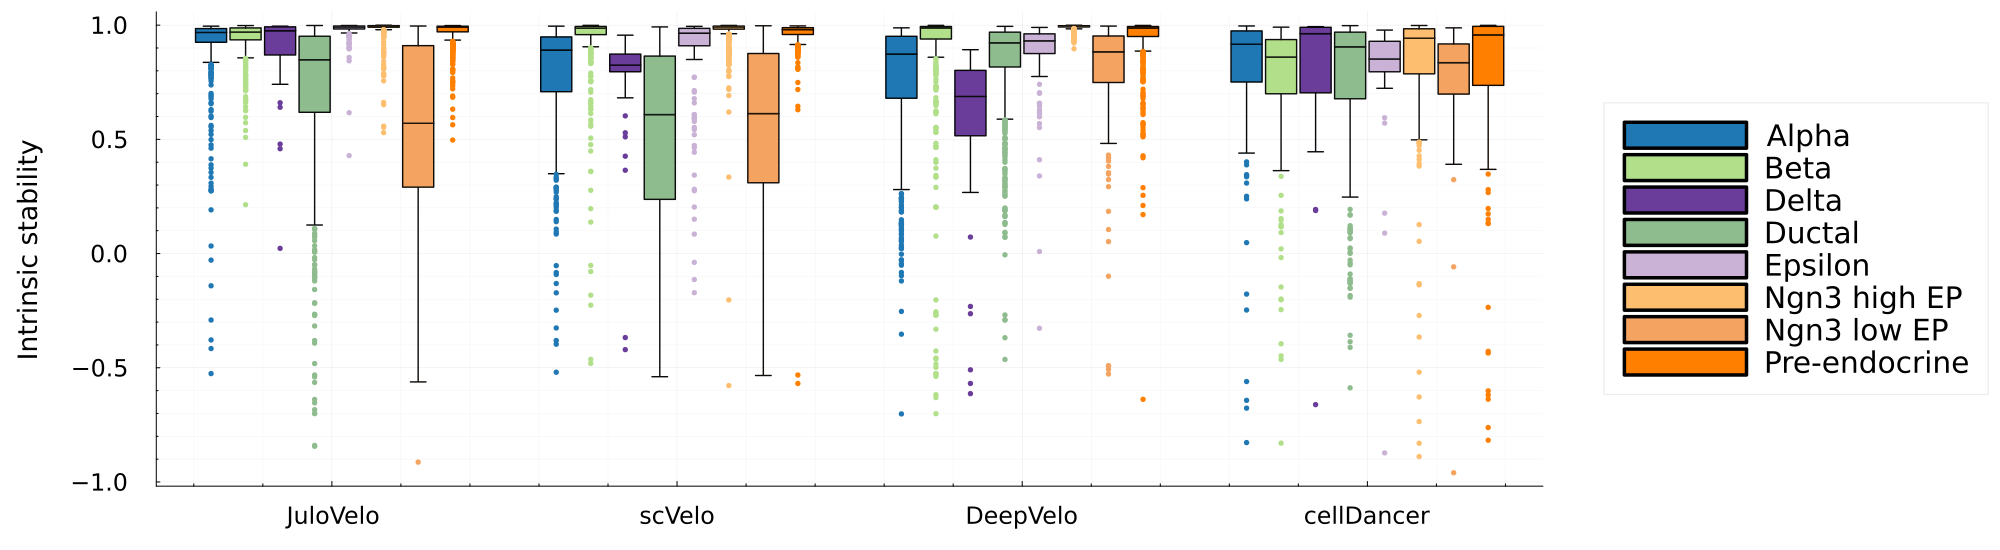

In [16]:
p = groupedboxplot(in_models, in_X, group = in_groups, size = (2000, 550), color = intrinsic_colors, legend = :outerright,
    tickfontsize = 16, guidefontsize = 18, left_margin = 1.5Plots.cm, bottom_margin = 1.0Plots.cm, legendfontsize = 20, ylabel = "Intrinsic stability"
)

In [17]:
savefig(p, "figure/pancreas_intrinsic_stability.png")

"/media/data/bmi111/KuanChiun/JuloVelo/thesis/results/pancreas/figure/pancreas_intrinsic_stability.png"

# Extrinsic stability

In [18]:
julovelo_extrinsic_stability = extrinsic_stability(julovelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap")
scvelo_extrinsic_stability = extrinsic_stability(scvelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap")
deepvelo_extrinsic_stability = extrinsic_stability(deepvelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap")
celldancer_extrinsic_stability = extrinsic_stability(celldancer_adata, differentiation_direction; xkey = "X_cdr", vkey = "velocity_cdr")

Dict{String, Vector{Float32}} with 4 entries:
  "Ductal"        => [0.408259, -0.512826, -0.255994, 0.477664, 0.793181, 0.192…
  "Pre-endocrine" => [0.57377, 0.758511, -0.094925, 0.990377, 0.173601, -0.2604…
  "Ngn3 low EP"   => [0.590839, -0.0390553, 0.216842, 0.301662, 0.570841, -0.39…
  "Ngn3 high EP"  => [-0.990259, 0.999999, 0.315943, 0.0765918, 0.474421, 0.957…

In [19]:
ex_X, ex_models, ex_groups = merge_for_boxplot(julovelo_extrinsic_stability, scvelo_extrinsic_stability, deepvelo_extrinsic_stability, celldancer_extrinsic_stability, extrinsic_labels)

(Float32[-0.2775676, -0.09993049, 0.50478446, 0.0428529, 0.7818893, 0.317271, 0.37763387, -0.4404734, -0.55753535, 0.43858463  …  0.6008217, -0.36379358, 0.5598025, 0.15191536, 0.3909373, 0.2942285, -0.031162707, 0.50820786, 0.5251258, 0.7582483], Any["JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo"  …  "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer"], Any["Ductal", "Ductal", "Ductal", "Ductal", "Ductal", "Ductal", "Ductal", "Ductal", "Ductal", "Ductal"  …  "Pre-endocrine", "Pre-endocrine", "Pre-endocrine", "Pre-endocrine", "Pre-endocrine", "Pre-endocrine", "Pre-endocrine", "Pre-endocrine", "Pre-endocrine", "Pre-endocrine"])

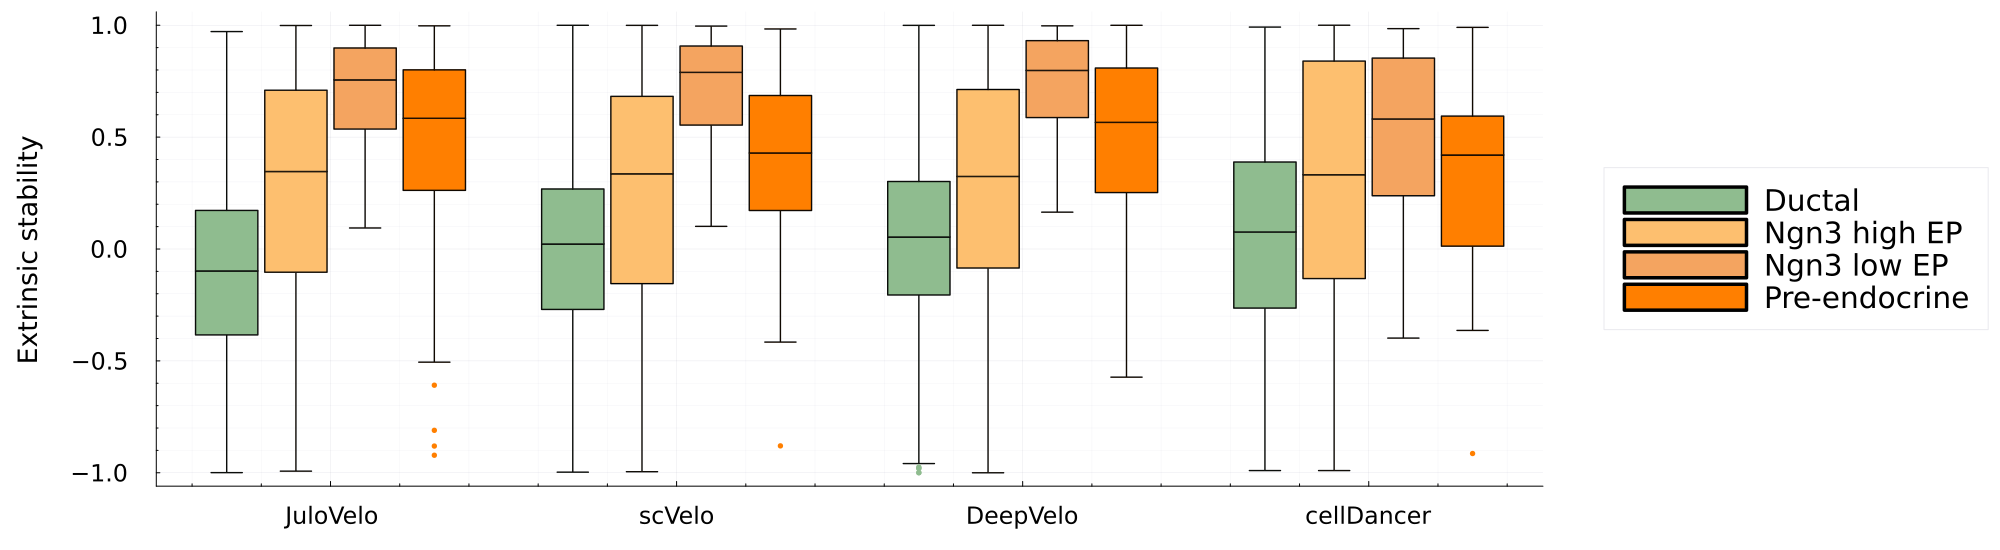

In [20]:
p = groupedboxplot(ex_models, ex_X, group = ex_groups, size = (2000, 550), color = extrinsic_colors, legend = :outerright,
    tickfontsize = 16, guidefontsize = 18, left_margin = 1.5Plots.cm, bottom_margin = 1.0Plots.cm, legendfontsize = 20, ylabel = "Extrinsic stability"
)

In [21]:
savefig(p, "figure/pancreas_extrinsic_stability.png")

"/media/data/bmi111/KuanChiun/JuloVelo/thesis/results/pancreas/figure/pancreas_extrinsic_stability.png"